In [1]:
import numpy as np
import pandas as pd

def load_synthetic_data():
    data = []
    for i in range (7):
        temp = pd.read_csv(f'./SynResLoadPattern/SynResLoadPattern_{i+1}.csv', header=None).to_numpy()
        data.append(temp)
    data = np.concatenate(data)
    return data

In [2]:
from sklearn_extra.cluster import CLARA
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler


def perform_clara(data, num_clusters, efficient_num):
    # Initialize CLARA with desired number of clusters
    clara = CLARA(n_clusters=num_clusters, random_state=42, n_sampling=data.shape[0]//efficient_num, max_iter = 600)

    # Fit the model
    clara.fit(data)

    # Predict the closest cluster each sample in X belongs to
    y_clara = clara.predict(data)
    return y_clara, clara.cluster_centers_

def perform_kmeans(data, num_clusters):
    kmeans = KMeans(n_clusters=num_clusters, max_iter = 600, random_state=42)
    kmeans.fit(data)
    y_kmeans = kmeans.predict(data)
    return y_kmeans, kmeans.cluster_centers_

def moving_average(data, window_size):
    weights = np.ones(window_size) / window_size
    return np.convolve(data, weights, mode='same')

def mini_max_scale(data):
    # Initialize the scaler
    scaler = MinMaxScaler(feature_range=(0, 1))

    # Scale the sequences
    scaled_data = np.array([scaler.fit_transform(seq.reshape(-1, 1)).flatten() for seq in data])
    return scaled_data

In [3]:
def split_clusters(data, num_clusters, clustering_labels):
    clustered_data = []
    for i in range(num_clusters):
        clustered_data.append(data[clustering_labels == i])
    return clustered_data

def random_select_from_clusters(clustered_data, num_samples):
    selected_cluster_samples = []
    for cluster in clustered_data:
        selected_cluster_samples.append(cluster[np.random.choice(cluster.shape[0], num_samples, replace=False)])
    return selected_cluster_samples

### Perform clusering

In [4]:
num_clusters = 5
data = load_synthetic_data()

processed_data = data

# apply miving average
processed_data = np.apply_along_axis(moving_average, axis=1, arr=processed_data, window_size=3)

# apply min-max scaling
processed_data = mini_max_scale(processed_data)

# perform clustering using processed data
# clustering_result, cluster_centers = perform_clara(data=processed_data, num_clusters=num_clusters, efficient_num=64)
clustering_result, cluster_centers = perform_kmeans(data=processed_data, num_clusters=num_clusters)

# split original data into clusters based on clustering results
clustered_data = split_clusters(data=data, num_clusters=num_clusters, clustering_labels=clustering_result)


### Generate Clustered data overview plot

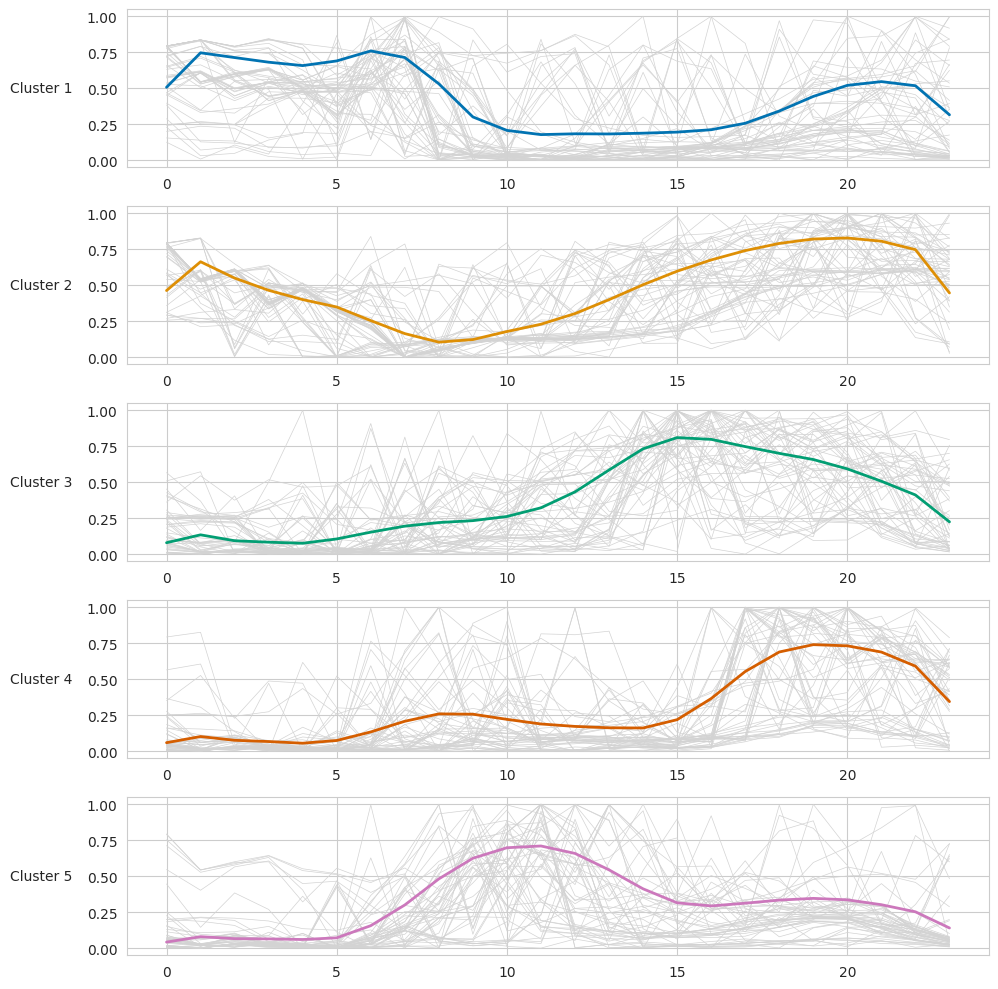

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns


# Select 50 random samples from each cluster for display purposes
cluster_samples = random_select_from_clusters(clustered_data=clustered_data, num_samples=50)

# Set Seaborn style
sns.set_style("whitegrid")

# Set Seaborn's color palette
palette = sns.color_palette("colorblind", 10)

# Background color for the sequences in 2D arrays
background_color = 'lightgray'

fig, axs = plt.subplots(len(clustered_data), 1, figsize=(10, 10))  # 10 rows, 1 column of subplots

for i, (arr_1d, arr_2d) in enumerate(zip(cluster_centers, cluster_samples)):
    for seq in arr_2d:
        axs[i].plot(seq, color=background_color, linewidth=0.5)  # Displaying each sequence in 2D array
    axs[i].plot(arr_1d, color=palette[i], linewidth=2)  # Overlaying 1D array on top with a distinct color
    axs[i].set_ylabel(f"Cluster {i+1}", rotation=0, labelpad=30, verticalalignment='center', fontsize=10)
    axs[i].yaxis.set_label_coords(-0.1,0.5)

plt.tight_layout()  # Adjusts spacing between subplots for better visualization

# save image
plt.savefig('./cluster_overview.png', dpi=600)

plt.show()

### Save data by clusters

In [9]:
# saved data by label
# clustered_data = []
# for i in range (7):
#     clustered_data.append([])
    
# for i in range (len(y_kmedoids)):
#     clustered_data[y_kmedoids[i]-1].append(data[i])
cluster_profile_counts = []
for i in range (len(clustered_data)):
    clustered_data[i] = np.array(clustered_data[i])
    cluster_profile_counts.append(clustered_data[i].shape[0])
    # np.save(f'./SynResLoadPatternClustered/cluster_{i+1}.npy', clustered_data[i])

# np.save(f'./SynResLoadPatternClustered/cluster_centres.npy', cluster_centers)

### Generate pie chart

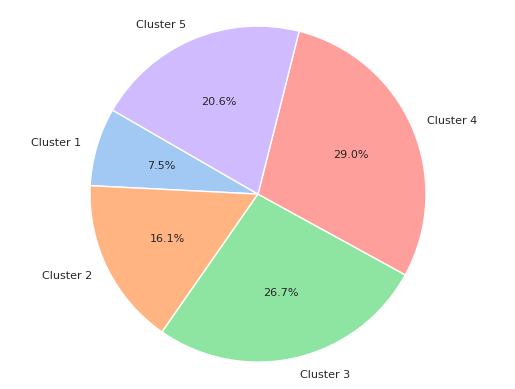

In [11]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Data
labels = []
for i in range (len(cluster_profile_counts)):
    labels.append(f'Cluster {i+1}')
sizes = cluster_profile_counts

# Function to format label with percentage and actual value
def func(pct, allvals):
    absolute = int(pct/100.*np.sum(allvals))
    # return "{:.1f}%\n({:d} profiles)".format(pct, absolute)
    return "{:.1f}%".format(pct)

# Plotting
fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct=lambda pct: func(pct, sizes), 
        startangle=150, colors=sns.color_palette("pastel", len(labels)),
        textprops={'fontsize': 8})  # Adjust the fontsize value here for numbers inside pie
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.savefig('./cluster_profile_distribution.png', dpi=600, bbox_inches='tight', pad_inches=0.01)
plt.show()
